In [2]:
import pandas as pd
from sqlalchemy import create_engine, text

# --- CONFIGURATION ---
DB_USER = "news_user"
DB_PASS = "news_password"
DB_HOST = "localhost"
DB_PORT = "5434"      # External Docker port
DB_NAME = "news"

# 1. Define Connection URL
DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# 2. Create Engine (This doesn't connect yet, just prepares the pool)
engine = create_engine(DATABASE_URL)

print(f"✅ Engine created for: {DB_USER}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

✅ Engine created for: news_user@localhost:5434/news


Distinct News Sources

In [12]:
# Get all unique sources
query = "SELECT DISTINCT source FROM news;"

with engine.connect() as conn:
    df_sources = pd.read_sql(query, conn)

display(df_sources)

,source
0,Donya-e-Eqtesad
1,IRNA
2,ISNA
3,Shargh
4,Tasnim


News Links

In [16]:
query_links = """
SELECT 
    source, 
    status, 
    COUNT(*) as count
FROM news_links
GROUP BY source, status
ORDER BY source, status;
"""

with engine.connect() as conn:
    df_links = pd.read_sql(query_links, conn)

display(df_links)

,source,status,count
0,Donya-e-Eqtesad,completed,101200
1,IRNA,pending,12
2,IRNA,completed,121460
3,ISNA,completed,225201
4,ISNA,failed,3696
5,Shargh,completed,109371
6,Shargh,failed,8886
7,Tasnim,completed,180870


In [17]:
query_quality = """
SELECT 
    source,
    -- Check for both NULL and Empty String ('')
    COUNT(*) FILTER (WHERE title IS NULL OR title = '' OR content IS NULL OR content = '') AS empty_or_null_count,
    COUNT(*) AS total_count
FROM news
GROUP BY source
ORDER BY empty_or_null_count DESC;
"""

with engine.connect() as conn:
    df_quality = pd.read_sql(query_quality, conn)

# Calculate percentage of bad data for better visibility
df_quality['bad_data_percent'] = (df_quality['empty_or_null_count'] / df_quality['total_count'] * 100).round(2)

display(df_quality)

,source,empty_or_null_count,total_count,bad_data_percent
0,Tasnim,8988,180870,4.97
1,Donya-e-Eqtesad,8465,101200,8.36
2,ISNA,1906,225201,0.85
3,IRNA,226,121460,0.19
4,Shargh,0,109371,0.00


First And Last timestamp of news for Publishers

In [18]:
query_dates = """
SELECT 
    source,
    MIN(published_datetime) as first_published,
    MAX(published_datetime) as last_published,
    -- Calculate duration of data coverage (Optional but useful)
    AGE(MAX(published_datetime), MIN(published_datetime)) as data_coverage_duration
FROM news
GROUP BY source
ORDER BY source;
"""

with engine.connect() as conn:
    df_dates = pd.read_sql(query_dates, conn)

display(df_dates)

,source,first_published,last_published,data_coverage_duration
0,Donya-e-Eqtesad,2024-11-29 04:34:56+00:00,2025-11-23 17:10:10+00:00,354 days 12:35:14
1,IRNA,2024-11-29 00:30:00+00:00,2025-11-23 20:38:00+00:00,354 days 20:08:00
2,ISNA,2024-11-29 00:03:00+00:00,2025-11-23 20:58:00+00:00,354 days 20:55:00
3,Shargh,2024-11-28 05:02:28+00:00,2025-11-23 21:54:23+00:00,355 days 16:51:55
4,Tasnim,2024-11-28 20:38:42+00:00,2025-11-23 17:02:51+00:00,354 days 20:24:09


Detailed Statistics of news

📅 Daily valid news counts (Last 10 days):


source,Donya-e-Eqtesad,IRNA,ISNA,Shargh,Tasnim
publish_date,,,,,
2025-11-23,115,585,637,167,573
2025-11-22,248,164,688,229,576
2025-11-21,220,387,326,179,374
2025-11-20,147,561,475,170,481
2025-11-19,260,746,766,276,578
2025-11-18,295,740,82,255,576
2025-11-17,264,450,670,283,579
2025-11-16,250,636,734,287,577
2025-11-15,263,616,713,277,583


<Axes: title={'center': 'Daily Valid News Count by Publisher'}, xlabel='publish_date'>

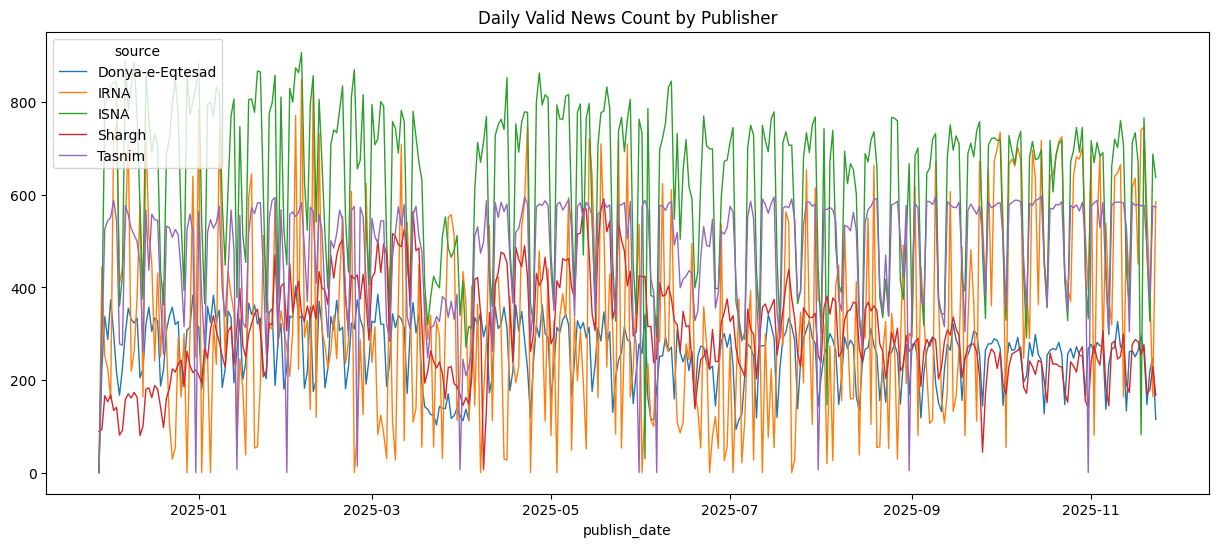

In [19]:
# 1. SQL Query: Filter for valid news and count by day
query_daily_stats = """
SELECT 
    source,
    DATE(published_datetime) as publish_date,
    COUNT(*) as valid_count
FROM news
WHERE 
    (title IS NOT NULL AND title != '') 
    AND 
    (content IS NOT NULL AND content != '')
GROUP BY source, DATE(published_datetime)
ORDER BY publish_date DESC, source;
"""

# 2. Load into DataFrame
with engine.connect() as conn:
    df_daily = pd.read_sql(query_daily_stats, conn)

# 3. Pivot the table for better readability
# Rows = Dates, Columns = Publishers, Values = Count
df_pivot = df_daily.pivot(index='publish_date', columns='source', values='valid_count')

# Fill NaN with 0 (days where a publisher had 0 news) and convert to integer
df_pivot = df_pivot.fillna(0).astype(int)

# 4. Display the last 10 days
print("📅 Daily valid news counts (Last 10 days):")
display(df_pivot.sort_index(ascending=False).head(10))

# 5. (Optional) Quick Visualization
# This helps spot days where a crawler might have failed (drops to 0)
df_pivot.plot(figsize=(15, 6), title="Daily Valid News Count by Publisher", lw=1)

In [20]:
import pandas as pd
import numpy as np

# 1. Fetch Daily Valid Counts
query = """
SELECT 
    source, 
    DATE(published_datetime) as publish_date, 
    COUNT(*) as count
FROM news
WHERE title != '' AND content != '' -- Valid news only
GROUP BY source, DATE(published_datetime)
"""

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# 2. Process: Pivot & Fill Missing Dates with 0
df['publish_date'] = pd.to_datetime(df['publish_date'])
full_date_range = pd.date_range(df['publish_date'].min(), df['publish_date'].max())

# Create a matrix: Rows=Dates, Cols=Sources, Values=Count
df_pivot = df.pivot(index='publish_date', columns='source', values='count')
df_pivot = df_pivot.reindex(full_date_range).fillna(0)

# 3. Generate Health Report
summary_data = []
outage_threshold_percent = 0.10  # Flag days with < 10% of median volume

print("--- 🩺 CRAWLER HEALTH CHECK ---")

for source in df_pivot.columns:
    daily_counts = df_pivot[source]
    median = daily_counts.median()
    
    # Identify specific bad dates
    # A "Bad Day" is either 0 news OR extremely low volume (<10% of normal)
    bad_days = daily_counts[daily_counts < (median * outage_threshold_percent)]
    bad_dates_list = bad_days.index.strftime('%Y-%m-%d').tolist()
    
    # Calculate Stability (Coefficient of Variation) - Lower is better
    stability = (daily_counts.std() / daily_counts.mean()) * 100 if daily_counts.mean() > 0 else 0
    
    summary_data.append({
        "Source": source,
        "Median Daily News": int(median),
        "Failures (Days)": len(bad_days),
        "Stability": f"{int(stability)}% (Lower=Better)",
        "Status": "✅ HEALTHY" if len(bad_days) < 5 else "⚠️ BROKEN"
    })
    
    # Print the specific dates if there are failures
    if bad_dates_list:
        print(f"\n❌ {source} failed on {len(bad_dates_list)} days:")
        print(f"   Dates: {bad_dates_list[:5]} {'...' if len(bad_dates_list)>5 else ''}")

# 4. Show Summary Table
print("\n--- SUMMARY TABLE ---")
display(pd.DataFrame(summary_data).set_index("Source"))

--- 🩺 CRAWLER HEALTH CHECK ---

❌ Donya-e-Eqtesad failed on 1 days:
   Dates: ['2024-11-28'] 

❌ IRNA failed on 26 days:
   Dates: ['2024-11-28', '2024-12-23', '2024-12-28', '2025-01-02', '2025-01-05'] ...

❌ ISNA failed on 2 days:
   Dates: ['2024-11-28', '2025-06-02'] 

❌ Shargh failed on 1 days:
   Dates: ['2025-04-08'] 

❌ Tasnim failed on 11 days:
   Dates: ['2024-11-28', '2024-12-31', '2025-01-14', '2025-01-31', '2025-02-24'] ...

--- SUMMARY TABLE ---


,Median Daily News,Failures (Days),Stability,Status
Source,,,,
Donya-e-Eqtesad,268,1,27% (Lower=Better),✅ HEALTHY
IRNA,310,26,64% (Lower=Better),⚠️ BROKEN
ISNA,691,2,29% (Lower=Better),✅ HEALTHY
Shargh,288,1,35% (Lower=Better),✅ HEALTHY
Tasnim,534,11,28% (Lower=Better),⚠️ BROKEN


Health Report Considering Links

In [21]:
import pandas as pd

unified_query = """
SELECT 
    nl.source,
    -- 1. Total Scope
    COUNT(*) as total_links_discovered,
    
    -- 2. Pipeline Success (Link Status)
    COUNT(*) FILTER (WHERE nl.status = 'completed') as links_marked_completed,
    
    -- 3. Actual Content Success (Joined Data)
    COUNT(n.id) FILTER (WHERE n.title != '' AND n.content != '') as valid_articles_stored,
    
    -- 4. Discrepancies (The "Sicknesses")
    -- Ghost: Link is 'completed' but no record exists in 'news'
    COUNT(*) FILTER (WHERE nl.status = 'completed' AND n.id IS NULL) as ghost_links,
    
    -- Empty: Record exists but content is blank
    COUNT(*) FILTER (WHERE n.id IS NOT NULL AND (n.title = '' OR n.content = '')) as empty_content_errors

FROM news_links nl
LEFT JOIN news n ON nl.link = n.link
GROUP BY nl.source
ORDER BY nl.source;
"""

with engine.connect() as conn:
    df_health = pd.read_sql(unified_query, conn)

# Calculate "True Success Rate"
df_health['success_rate'] = (df_health['valid_articles_stored'] / df_health['total_links_discovered'] * 100).round(1)

display(df_health)

,source,total_links_discovered,links_marked_completed,valid_articles_stored,ghost_links,empty_content_errors,success_rate
0,Donya-e-Eqtesad,101200,101200,92735,0,8465,91.6
1,IRNA,121472,121460,121234,0,226,99.8
2,ISNA,228897,225201,223295,0,1906,97.6
3,Shargh,118257,109371,109371,0,0,92.5
4,Tasnim,180870,180870,171882,0,8988,95.0
